# Modelisation of credit data

In [3]:
import sys
print(sys.version)
print(sys.executable)
print(sys.version)
print(sys.version_info)

3.11.11 (main, Dec 04 2024, 21:44:34) [GCC]
/home/etienne/.cache/uv/archive-v0/ZDgdDg5Ivwoqv_zV22qO3/bin/python
3.11.11 (main, Dec 04 2024, 21:44:34) [GCC]
sys.version_info(major=3, minor=11, micro=11, releaselevel='final', serial=0)


In [4]:
import warnings

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import (
    EditedNearestNeighbours,
    NearMiss,
    RandomUnderSampler,
)
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import LinearSVC

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 150)

In [4]:
## Load data
data = pd.read_csv("Data/cleaned/data_train.csv")
data.drop(columns=["SK_ID_CURR"], inplace=True)
data

,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_CNT_CREDIT_PROLONG_SUM,BURO_MONTHS_BALANCE_MAX_MAX,BURO_CREDIT_ACTIVE_Bad debt_MEAN,BURO_CREDIT_ACTIVE_Sold_MEAN,BURO_CREDIT_CURRENCY_currency 1_MEAN,BURO_CREDIT_CURRENCY_currency 3_MEAN,BURO_CREDIT_CURRENCY_currency 4_MEAN,BURO_CREDIT_TYPE_Another type of loan_MEAN,BURO_CREDIT_TYPE_Car loan_MEAN,BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN,BURO_CREDIT_TYPE_Consumer credit_MEAN,BURO_CREDIT_TYPE_Interbank credit_MEAN,BURO_CREDIT_TYPE_Loan for business development_MEAN,BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN,BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN,BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,BURO_CREDIT_TYPE_Mobile operator loan_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_CREDIT_TYPE_Real estate loan_MEAN,BURO_CREDIT_TYPE_Unknown type of loan_MEAN,BURO_STATUS_0_MEAN_MEAN,BURO_STATUS_1_MEAN_MEAN,BURO_STATUS_2_MEAN_MEAN,BURO_STATUS_3_MEAN_MEAN,BURO_STATUS_C_MEAN_MEAN,BURO_STATUS_X_MEAN_MEAN,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_CNT_PAYMENT_MEAN,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,INSTAL_COUNT,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MIN,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_DRAWINGS_CURRENT_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,CC_AMT_DRAWINGS_POS_CURRENT_MIN,CC_AMT_DRAWINGS_POS_CURRENT_MAX,CC_SK_DPD_MIN,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,TARGET
0,1,0,202500.0,406597.5,0.018801,-9461,-637.0,-3648.0,-2120,2,10,0,0,0,0,0.262949,0.139376,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1437.0,-103.0,0.0,31988.565,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.406960,0.255682,0.000000,0.0,0.175426,0.161932,9251.775,9251.775,9.0,9.0,-606.0,-606.0,24.000000,-1.0,-10.000000,19.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,19.0,-1.0,-1.0,869873.535,1354829.265,1350000.0,1350000.0,1125000.0,112500.0,1529847.0,720177.435,2060030.16,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1
1,0,0,270000.0,1293502.5,0.003541,-16765,-1188.0,-1186.0,-291,1,11,0,0,0,0,0.622246,0.896010,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,

In [5]:
# Creation of trainning and test dataset
X_train, X_test, y_train, y_test = train_test_split(
    data[data.columns[data.columns != "TARGET"]],
    data["TARGET"],
    test_size=0.3,
    random_state=3,
    stratify=data["TARGET"],
)

In [6]:
X_train

,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_CNT_CREDIT_PROLONG_SUM,BURO_MONTHS_BALANCE_MAX_MAX,BURO_CREDIT_ACTIVE_Bad debt_MEAN,BURO_CREDIT_ACTIVE_Sold_MEAN,BURO_CREDIT_CURRENCY_currency 1_MEAN,BURO_CREDIT_CURRENCY_currency 3_MEAN,BURO_CREDIT_CURRENCY_currency 4_MEAN,BURO_CREDIT_TYPE_Another type of loan_MEAN,BURO_CREDIT_TYPE_Car loan_MEAN,BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN,BURO_CREDIT_TYPE_Consumer credit_MEAN,BURO_CREDIT_TYPE_Interbank credit_MEAN,BURO_CREDIT_TYPE_Loan for business development_MEAN,BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN,BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN,BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,BURO_CREDIT_TYPE_Mobile operator loan_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_CREDIT_TYPE_Real estate loan_MEAN,BURO_CREDIT_TYPE_Unknown type of loan_MEAN,BURO_STATUS_0_MEAN_MEAN,BURO_STATUS_1_MEAN_MEAN,BURO_STATUS_2_MEAN_MEAN,BURO_STATUS_3_MEAN_MEAN,BURO_STATUS_C_MEAN_MEAN,BURO_STATUS_X_MEAN_MEAN,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_CNT_PAYMENT_MEAN,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,INSTAL_COUNT,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MIN,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_DRAWINGS_CURRENT_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,CC_AMT_DRAWINGS_POS_CURRENT_MIN,CC_AMT_DRAWINGS_POS_CURRENT_MAX,CC_SK_DPD_MIN,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX
293239,1,0,292500.0,760225.5,0.046220,-11577,-1384.0,-3901.0,-3287,1,12,0,0,0,0,0.759447,0.672243,-1639.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-2118.0,-1480.0,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,1.000000,0.833333,0.240741,0.4,1.000000,1.000000,2250.000,52156.665,11.0,21.0,-2888.0,-109.0,11.428571,-2.0,-42.594595,74.0,0.0,0.932432,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,88.0,-12.0,-2.0,0.000,146804.850,45000.0,247500.0,0.0,0.0,0.0,1935.000,148763.70,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
178837,1,0,135000.0,360000.0,0.025164,-8416,-1717.0,-7716.0,-1081,2,14,0,0,0,0,0.547058,0.626304,-925.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.

In [7]:
# Ratio Target = 0 / Target = 1 in train dataset
print(
    "There is",
    (y_train.value_counts()[1] / len(X_train)) * 100,
    "% of clients that did not paid their loan in the trainning set",
)

There is 8.072788426695904 % of clients that did not paid their loan in the trainning set


In [8]:
# Ratio Target = 0 / Target = 1 in test dataset
print(
    "There is",
    (y_test.value_counts()[1] / len(X_test)) * 100,
    "% of clients that did not paid their loan in the trainning set",
)

There is 8.073450185901814 % of clients that did not paid their loan in the trainning set


In [9]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")

# Sets the current active experiment
# returns the Experiment metadata
imbalance_experiment = mlflow.set_experiment("imbalance")

## Correcting the imbalanced data
    Firstly, I will examine the best approach to address the fact that our data primarily contains information about clients who have repaid their loans. I will use logistic regression to determine whether overfitting, underfitting, or adjusting class weights yields the best results.

    Moreover, I will select the best model using the scoring metric optimized for our system.
    I included the fact that a client who does not repay their loan costs ten times more than a client who would not receive credit. I also included the fact that only 92% of our data concerns individuals who have paid their credit.
    
    Score_metier = (TP x 0.08 + TN x 0.92) / (TP x 0.08 + TN  x 0.92 + 10FN  x 0.92 + FP x 0.08)

### Reference

In [11]:
# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "LR_imbalanced_scaled_data"
# Define an artifact path that the model will be saved to.
artifact_path = "lr_imbalanced_scaled"

pipeline = Pipeline([("scaler", RobustScaler()), ("model", LogisticRegression())])

with mlflow.start_run(run_name=run_name) as run:
    # Entraîner le pipeline
    pipeline.fit(X_train, y_train)

    # Faire des prédictions
    predictions = pipeline.predict(X_test)

    # Enregistrer le modèle dans MLflow
    confusion_mat = confusion_matrix(y_test, predictions)

    metrics = {
        "AUC": roc_auc_score(y_test, predictions),
        "F1_score": f1_score(y_test, predictions),
        "Precission": precision_score(y_test, predictions),
        "Recall": recall_score(y_test, predictions),
        "True_negative": confusion_mat[0][0],
        "False_negative": confusion_mat[1][0],
        "True_positive": confusion_mat[1][1],
        "False_positive": confusion_mat[0][1],
        "score_metier": (confusion_mat[1][1] * 0.08 + confusion_mat[0][0] * 0.92)
        / (
            confusion_mat[1][1] * 0.08
            + confusion_mat[0][0] * 0.92
            + 10 * confusion_mat[1][0] * 0.92
            + confusion_mat[0][1] * 0.08
        ),
    }

    mlflow.log_params(
        {
            "lenght_0": sum(y_train == 0),
            "lenght_1": sum(y_train == 1),
            "Sampling": "None",
        }
    )
    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)

🏃 View run LR_imbalanced_scaled_data at: http://127.0.0.1:8080/#/experiments/576506674894813173/runs/2b179abad3664bd4a8211f4352c0d834
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/576506674894813173


### Weighted classes
    Logistic regression with weighted classes option

In [13]:
# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "LR_imbalanced_scaled_data_weighted"
# Define an artifact path that the model will be saved to.
artifact_path = "lr_weight"

pipeline = Pipeline(
    [("scaler", RobustScaler()), ("model", LogisticRegression(class_weight="balanced"))]
)

with mlflow.start_run(run_name=run_name) as run:
    # Entraîner le pipeline
    pipeline.fit(X_train, y_train)

    # Faire des prédictions
    predictions = pipeline.predict(X_test)

    # Enregistrer le modèle dans MLflow
    confusion_mat = confusion_matrix(y_test, predictions)

    metrics = {
        "AUC": roc_auc_score(y_test, predictions),
        "F1_score": f1_score(y_test, predictions),
        "Precission": precision_score(y_test, predictions),
        "Recall": recall_score(y_test, predictions),
        "True_negative": confusion_mat[0][0],
        "False_negative": confusion_mat[1][0],
        "True_positive": confusion_mat[1][1],
        "False_positive": confusion_mat[0][1],
        "score_metier": (confusion_mat[1][1] * 0.08 + confusion_mat[0][0] * 0.92)
        / (
            confusion_mat[1][1] * 0.08
            + confusion_mat[0][0] * 0.92
            + 10 * confusion_mat[1][0] * 0.92
            + confusion_mat[0][1] * 0.08
        ),
    }

    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)

    mlflow.log_params(
        {
            "lenght_0": sum(y_train == 0),
            "lenght_1": sum(y_train == 1),
            "Sampling": "Weight classes",
        }
    )

🏃 View run LR_imbalanced_scaled_data_weighted at: http://127.0.0.1:8080/#/experiments/576506674894813173/runs/7ab4934dc9704ac8acb25a7e9542e335
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/576506674894813173


### Oversampling
    Oversampling using SMOTE algorithm.

In [15]:
# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "LR_smote_data"
# Define an artifact path that the model will be saved to.
artifact_path = "lr_SMOTE"

pipeline = ImbPipeline(
    [
        ("Oversampling", SMOTE(random_state=3)),
        ("scaler", RobustScaler()),
        ("model", LogisticRegression()),
    ]
)

with mlflow.start_run(run_name=run_name) as run:
    # Entraîner le pipeline
    pipeline.fit(X_train, y_train)
    # Récupérer X_resampled et y_resampled après SMOTE
    X_train_resample, y_train_resample = pipeline.named_steps[
        "Oversampling"
    ].fit_resample(X_train, y_train)

    # Faire des prédictions
    predictions = pipeline.predict(X_test)

    # Enregistrer le modèle dans MLflow
    confusion_mat = confusion_matrix(y_test, predictions)

    metrics = {
        "AUC": roc_auc_score(y_test, predictions),
        "F1_score": f1_score(y_test, predictions),
        "Precission": precision_score(y_test, predictions),
        "Recall": recall_score(y_test, predictions),
        "True_negative": confusion_mat[0][0],
        "False_negative": confusion_mat[1][0],
        "True_positive": confusion_mat[1][1],
        "False_positive": confusion_mat[0][1],
        "score_metier": (confusion_mat[1][1] * 0.08 + confusion_mat[0][0] * 0.92)
        / (
            confusion_mat[1][1] * 0.08
            + confusion_mat[0][0] * 0.92
            + 10 * confusion_mat[1][0] * 0.92
            + confusion_mat[0][1] * 0.08
        ),
    }

    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)

    # Log the parameters used for the model fit
    mlflow.log_params(
        {
            "lenght_0": sum(y_train_resample == 0),
            "lenght_1": sum(y_train_resample == 1),
            "Sampling": "SMOTE",
        }
    )

🏃 View run LR_smote_data at: http://127.0.0.1:8080/#/experiments/576506674894813173/runs/106edb0b2efa4001b3958d9902c4d2fd
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/576506674894813173


### NearMiss Undersampling
Undersampling using NearMiss Algorithm.

In [17]:
# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "LR_nearmiss_data"
# Define an artifact path that the model will be saved to.
artifact_path = "lr_nearmiss"

pipeline = ImbPipeline(
    [
        ("Undersampling", NearMiss()),
        ("scaler", RobustScaler()),
        ("model", LogisticRegression()),
    ]
)

with mlflow.start_run(run_name=run_name) as run:
    # Entraîner le pipeline
    pipeline.fit(X_train, y_train)
    # Récupérer X_resampled et y_resampled après SMOTE
    X_train_resample, y_train_resample = pipeline.named_steps[
        "Undersampling"
    ].fit_resample(X_train, y_train)

    # Faire des prédictions
    predictions = pipeline.predict(X_test)

    # Enregistrer le modèle dans MLflow
    confusion_mat = confusion_matrix(y_test, predictions)

    metrics = {
        "AUC": roc_auc_score(y_test, predictions),
        "F1_score": f1_score(y_test, predictions),
        "Precission": precision_score(y_test, predictions),
        "Recall": recall_score(y_test, predictions),
        "True_negative": confusion_mat[0][0],
        "False_negative": confusion_mat[1][0],
        "True_positive": confusion_mat[1][1],
        "False_positive": confusion_mat[0][1],
        "score_metier": (confusion_mat[1][1] * 0.08 + confusion_mat[0][0] * 0.92)
        / (
            confusion_mat[1][1] * 0.08
            + confusion_mat[0][0] * 0.92
            + 10 * confusion_mat[1][0] * 0.92
            + confusion_mat[0][1] * 0.08
        ),
    }

    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)

    # Log the parameters used for the model fit
    mlflow.log_params(
        {
            "lenght_0": sum(y_train_resample == 0),
            "lenght_1": sum(y_train_resample == 1),
            "Sampling": "Near Miss",
        }
    )

🏃 View run LR_nearmiss_data at: http://127.0.0.1:8080/#/experiments/576506674894813173/runs/9cf3cb0f3c8a46b6a0343b82edb760ea
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/576506674894813173


### Edited Nearest Neigbours Undersampling
    Undersampling with EditedNearestNeigbours Algorithm.

In [19]:
# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "LR_EditedNearestNeighbours_data"
# Define an artifact path that the model will be saved to.
artifact_path = "lr_ENN"

pipeline = ImbPipeline(
    [
        ("ENN", EditedNearestNeighbours()),
        ("scaler", RobustScaler()),
        ("model", LogisticRegression()),
    ]
)

with mlflow.start_run(run_name=run_name) as run:
    # Entraîner le pipeline
    pipeline.fit(X_train, y_train)
    # Récupérer X_resampled et y_resampled après SMOTE
    X_train_resample, y_train_resample = pipeline.named_steps["ENN"].fit_resample(
        X_train, y_train
    )

    # Faire des prédictions
    predictions = pipeline.predict(X_test)

    # Enregistrer le modèle dans MLflow
    confusion_mat = confusion_matrix(y_test, predictions)

    metrics = {
        "AUC": roc_auc_score(y_test, predictions),
        "F1_score": f1_score(y_test, predictions),
        "Precission": precision_score(y_test, predictions),
        "Recall": recall_score(y_test, predictions),
        "True_negative": confusion_mat[0][0],
        "False_negative": confusion_mat[1][0],
        "True_positive": confusion_mat[1][1],
        "False_positive": confusion_mat[0][1],
        "score_metier": (confusion_mat[1][1] * 0.08 + confusion_mat[0][0] * 0.92)
        / (
            confusion_mat[1][1] * 0.08
            + confusion_mat[0][0] * 0.92
            + 10 * confusion_mat[1][0] * 0.92
            + confusion_mat[0][1] * 0.08
        ),
    }

    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)

    # Log the parameters used for the model fit
    mlflow.log_params(
        {
            "lenght_0": sum(y_train_resample == 0),
            "lenght_1": sum(y_train_resample == 1),
            "Sampling": "ENN",
        }
    )

🏃 View run LR_EditedNearestNeighbours_data at: http://127.0.0.1:8080/#/experiments/576506674894813173/runs/ce6d8d83dcc94f17aa9532a24a4d24e9
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/576506674894813173


### Combination of Over and Undersampling

In [21]:
# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "LR_SMOTE_Under"
# Define an artifact path that the model will be saved to.
artifact_path = "lr_SMOTE_Under"

over, under = 0.1, 0.75

pipeline = ImbPipeline(
    [
        ("Oversampling", SMOTE(sampling_strategy=over)),
        ("Undersampling", RandomUnderSampler(sampling_strategy=under)),
        ("scaler", RobustScaler()),
        ("model", LogisticRegression()),
    ]
)

with mlflow.start_run(run_name=run_name) as run:
    # Entraîner le pipeline
    pipeline.fit(X_train, y_train)
    # Récupérer X_resampled et y_resampled après SMOTE
    X_train_resample, y_train_resample = pipeline.named_steps[
        "Undersampling"
    ].fit_resample(X_train, y_train)

    # Faire des prédictions
    predictions = pipeline.predict(X_test)

    # Enregistrer le modèle dans MLflow
    confusion_mat = confusion_matrix(y_test, predictions)

    metrics = {
        "AUC": roc_auc_score(y_test, predictions),
        "F1_score": f1_score(y_test, predictions),
        "Precission": precision_score(y_test, predictions),
        "Recall": recall_score(y_test, predictions),
        "True_negative": confusion_mat[0][0],
        "False_negative": confusion_mat[1][0],
        "True_positive": confusion_mat[1][1],
        "False_positive": confusion_mat[0][1],
        "score_metier": (confusion_mat[1][1] * 0.08 + confusion_mat[0][0] * 0.92)
        / (
            confusion_mat[1][1] * 0.08
            + confusion_mat[0][0] * 0.92
            + 10 * confusion_mat[1][0] * 0.92
            + confusion_mat[0][1] * 0.08
        ),
    }

    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)

    # Log the parameters used for the model fit
    mlflow.log_params(
        {
            "lenght_0": sum(y_train_resample == 0),
            "lenght_1": sum(y_train_resample == 1),
            "Sampling": "SMOTE + Under",
        }
    )

🏃 View run LR_SMOTE_Under at: http://127.0.0.1:8080/#/experiments/576506674894813173/runs/dbef65dc9f404eb487b7fda10d5d7f8e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/576506674894813173


## Feature selection
    Based on the previous results, the best way to deal with our imbalance dataset is to use weighted classes option. 
    I am now looking at the feature importance in this model in order to remove useless feature for the future modelling. 
### Permutation importance

In [43]:
# Permutation Importance
pipeline = Pipeline(
    [("scaler", RobustScaler()), ("model", LogisticRegression(class_weight="balanced"))]
)

# Entraîner le pipeline
pipeline.fit(X_train, y_train)

model = pipeline.named_steps["model"]

# Extraire les données prétraitées (transformées par le pipeline, sauf le modèle final)
X_test_transformed = pipeline.named_steps["scaler"].transform(X_test)

perm_importance = permutation_importance(
    model, X_test_transformed, y_test, n_repeats=100, random_state=3, n_jobs=-1
)
perm_importance_df = pd.DataFrame(
    {
        "Feature": X_train.columns,
        "Importance Mean": perm_importance.importances_mean,
        "Importance Std": perm_importance.importances_std,
    }
)
print("\nPermutation Importance:")
print(perm_importance_df.sort_values(by="Importance Mean", ascending=False))


Permutation Importance:
                              Feature  Importance Mean  Importance Std
22          AMT_REQ_CREDIT_BUREAU_QRT         0.052697        0.000731
38       BURO_CREDIT_DAY_OVERDUE_MEAN         0.052027        0.000666
21          AMT_REQ_CREDIT_BUREAU_MON         0.022644        0.000450
23         AMT_REQ_CREDIT_BUREAU_YEAR         0.008160        0.000310
19          AMT_REQ_CREDIT_BUREAU_DAY         0.006453        0.000234
..                                ...              ...             ...
87              CC_MONTHS_BALANCE_MIN        -0.028898        0.000580
97    CC_AMT_DRAWINGS_POS_CURRENT_MAX        -0.036228        0.000795
96    CC_AMT_DRAWINGS_POS_CURRENT_MIN        -0.036234        0.000797
94  CC_AMT_DRAWINGS_OTHER_CURRENT_MIN        -0.042703        0.000632
95  CC_AMT_DRAWINGS_OTHER_CURRENT_MAX        -0.042845        0.000639

[108 rows x 3 columns]


In [53]:
# List of features with no effect on the model
useless_features = perm_importance_df.loc[
    perm_importance_df["Importance Mean"] <= 0.0001, "Feature"
].to_list()
len(useless_features)

89

### Data processing

In [56]:
X_train.drop(columns=useless_features, inplace=True)
X_test.drop(columns=useless_features, inplace=True)

In [58]:
X_train.to_csv("Data/cleaned/X_train.csv", index=False)
y_train.to_csv("Data/cleaned/y_train.csv", index=False)
X_test.to_csv("Data/cleaned/X_test.csv", index=False)
y_test.to_csv("Data/cleaned/y_test.csv", index=False)

In [59]:
test_data = pd.read_csv("Data/cleaned/data_test.csv")
test_data.drop(columns=useless_features, inplace=True)
test_data.to_csv("Data/cleaned/data4test.csv", index=False)

## Model selection


In [87]:
X_train = pd.read_csv("Data/cleaned/X_train.csv")
y_train = pd.read_csv("Data/cleaned/y_train.csv")
y_train = y_train.values
X_test = pd.read_csv("Data/cleaned/X_test.csv")
y_test = pd.read_csv("Data/cleaned/y_test.csv")
y_test = y_test.values

In [89]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")

# Sets the current active experiment to the "Apple_Models" experiment and
# returns the Experiment metadata
imbalance_experiment = mlflow.set_experiment("Best_model_selection")

In [91]:
# Fonction for trainning models
def test_model(X, y, X_test, y_test, model, params, name):
    """
    Here is a fonction for trainning a model in a pipeline for data X and y.
    """
    # X : X_train dataset
    # y: y_train
    # X_test, y_test: X_test, y_test
    # model: model to test
    # params: params for gridsearchcv Warning: add "model__" in order to pass the params to the model
    # name: name use for saving the run in mlflow

    # Define a run name for this iteration of training.
    # If this is not set, a unique name will be auto-generated for your run.
    run_name = name
    # Define an artifact path that the model will be saved to.
    artifact_path = name

    pipeline = Pipeline([("scaler", RobustScaler()), ("model", model)])

    # Définir la fonction Score
    def score(predict, actual):
        confusion_mat = confusion_matrix(predict, actual)
        score_metier = (confusion_mat[1][1] * 0.08 + confusion_mat[0][0] * 0.92) / (
            confusion_mat[1][1] * 0.08
            + confusion_mat[0][0] * 0.92
            + 10 * confusion_mat[1][0] * 0.92
            + confusion_mat[0][1] * 0.08
        )
        return score_metier

    # Créer un scoreur à partir de la fonction score
    score_metier = make_scorer(score, greater_is_better=True)

    with mlflow.start_run(run_name=run_name) as run:
        # Entraîner le pipeline
        grid_search = GridSearchCV(
            pipeline,
            param_grid=params,
            cv=5,
            scoring=score_metier,
            refit=True,
            n_jobs=-1,
            verbose=1,
        )

        # Fit the model
        grid_search.fit(X, y)

        # Best model
        best_model = grid_search.best_estimator_

        # Log the parameters used for the model fit
        mlflow.log_params(grid_search.best_params_)

        # Predciction
        predictions = best_model.predict(X_test)

        confusion_mat = confusion_matrix(y_test, predictions)

        metrics = {
            "AUC": roc_auc_score(y_test, predictions),
            "F1_score": f1_score(y_test, predictions),
            "Precission": precision_score(y_test, predictions),
            "Recall": recall_score(y_test, predictions),
            "True_negative": confusion_mat[0][0],
            "False_negative": confusion_mat[1][0],
            "True_positive": confusion_mat[1][1],
            "False_positive": confusion_mat[0][1],
            "Score_metier": (confusion_mat[1][1] * 0.08 + confusion_mat[0][0] * 0.92)
            / (
                confusion_mat[1][1] * 0.08
                + confusion_mat[0][0] * 0.92
                + 10 * confusion_mat[1][0] * 0.92
                + confusion_mat[0][1] * 0.08
            ),
        }

        # Log the error metrics that were calculated during validation
        mlflow.log_metrics(metrics)

        # Log an instance of the trained model for later use
        mlflow.sklearn.log_model(
            sk_model=name, input_example=X_test, artifact_path=artifact_path
        )

### Dummy Classifier

In [94]:
# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "Dummy"
# Define an artifact path that the model will be saved to.
artifact_path = "dummy"

pipeline = Pipeline(
    [("scaler", RobustScaler()), ("model", DummyClassifier(strategy="most_frequent"))]
)

with mlflow.start_run(run_name=run_name) as run:
    # Entraîner le pipeline
    pipeline.fit(X_train, y_train)

    # Faire des prédictions
    predictions = pipeline.predict(X_test)

    # Enregistrer le modèle dans MLflow
    confusion_mat = confusion_matrix(y_test, predictions)

    metrics = {
        "AUC": roc_auc_score(y_test, predictions),
        "F1_score": f1_score(y_test, predictions),
        "Precission": precision_score(y_test, predictions),
        "Recall": recall_score(y_test, predictions),
        "True_negative": confusion_mat[0][0],
        "False_negative": confusion_mat[1][0],
        "True_positive": confusion_mat[1][1],
        "False_positive": confusion_mat[0][1],
        "Score_metier": (confusion_mat[1][1] * 0.08 + confusion_mat[0][0] * 0.92)
        / (
            confusion_mat[1][1] * 0.08
            + confusion_mat[0][0] * 0.92
            + 10 * confusion_mat[1][0] * 0.92
            + confusion_mat[0][1] * 0.08
        ),
    }

    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)

🏃 View run Dummy at: http://127.0.0.1:8080/#/experiments/241528793374745453/runs/63e5086faacf44e281549e9966f46ba2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/241528793374745453


### Logistic regression

In [97]:
run_name = "Logistic_regression"

grid_param = {
    "model__class_weight": ["balanced"],
    "model__tol": [0.0001, 0.0003],
    "model__C": [1.0, 3.0],
    "model__max_iter": [500, 1000],
}

In [99]:
test_model(X_train, y_train.flatten(), X_test, y_test.flatten(), LogisticRegression(), grid_param, run_name)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/etienne/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/etienne/software/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

🏃 View run Logistic_regression at: http://127.0.0.1:8080/#/experiments/241528793374745453/runs/1af2a14f11184469b4c7b550e08fed29
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/241528793374745453


### K-nearest neighbors

In [101]:
run_name = "KNC"

grid_param = {
    "model__n_neighbors": [3],
    "model__weights": ["uniform"],
    "model__algorithm": ["ball_tree"],
    "model__leaf_size": [30],
    "model__p": [1],
}

In [102]:
test_model(
    X_train, y_train.flatten(), X_test, y_test.flatten(), KNeighborsClassifier(), grid_param, run_name
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2025/02/12 19:36:31 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'predict'"). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.
2025/02/12 19:36:31 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



🏃 View run KNC at: http://127.0.0.1:8080/#/experiments/241528793374745453/runs/b634205c1364460f9a4ade7db01a56f2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/241528793374745453


### SVC

In [103]:
run_name = "SVC"

grid_param = {
    "model__class_weight": ["balanced"],
    "model__C": [0.01, 0.1, 1],
    "model__intercept_scaling": [1, 3],
    "model__random_state": [3],
}

In [104]:
test_model(X_train, y_train.flatten(), X_test, y_test.flatten(), LinearSVC(), grid_param, run_name)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


2025/02/12 19:37:06 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'predict'"). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.
2025/02/12 19:37:06 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



🏃 View run SVC at: http://127.0.0.1:8080/#/experiments/241528793374745453/runs/f13cd5e2adab47b7ae808a66b82bb098
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/241528793374745453


### Descision tree
#### Random forest

In [106]:
run_name = "random_forest"

grid_param = {
    "model__class_weight": ["balanced"],
    "model__n_estimators": [50, 100, 300],
    "model__max_features": ["sqrt"],
    "model__max_depth": list(range(2, 10, 2)),
    "model__random_state": [3],
}

In [107]:
test_model(
    X_train, y_train.flatten(), X_test, y_test.flatten(), RandomForestClassifier(), grid_param, run_name
)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


2025/02/12 19:49:27 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'str' object has no attribute 'predict'"). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.
2025/02/12 19:49:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



🏃 View run random_forest at: http://127.0.0.1:8080/#/experiments/241528793374745453/runs/ccc30b3d8b6a4176ab45ca229d803faf
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/241528793374745453


#### XGboost

In [109]:
run_name = "xgboost"

pos_class_weight = (len(y_train) - np.sum(y_train)) / np.sum(y_train)

grid_param = {
    "model__objective": ["binary:logistic"],
    "model__scale_pos_weight": [pos_class_weight],
    "model__seed": [3],
    "model__max_depth": [3, 5, 7, 9],
    "model__n_estimators": [50, 100, 200],
    "model__learning_rate": [0.1, 0.3],
}

pipeline = Pipeline([("scaler", RobustScaler()), ("model", xgb.XGBClassifier())])


# Définir la fonction Score
def score(predict, actual):
    confusion_mat = confusion_matrix(predict, actual)
    score_metier = (confusion_mat[1][1] * 0.08 + confusion_mat[0][0] * 0.92) / (
        confusion_mat[1][1] * 0.08
        + confusion_mat[0][0] * 0.92
        + 10 * confusion_mat[1][0] * 0.92
        + confusion_mat[0][1] * 0.08
    )
    return float(score_metier)


# Créer un scoreur à partir de la fonction score
score_metier = make_scorer(score, greater_is_better=True)

with mlflow.start_run(run_name=run_name) as run:
    # Entraîner le pipeline
    grid_search = GridSearchCV(
        pipeline,
        param_grid=grid_param,
        cv=5,
        scoring=score_metier,
        refit=True,
        n_jobs=-1,
        verbose=1,
    )

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Best model
    best_model = grid_search.best_estimator_
    best_classifier = best_model.named_steps["model"]

    # Log the parameters used for the model fit
    mlflow.log_params(grid_search.best_params_)

    # Predciction
    predictions = best_model.predict(X_test)

    confusion_mat = confusion_matrix(y_test, predictions)

    metrics = {
        "AUC": roc_auc_score(y_test, predictions),
        "F1_score": f1_score(y_test, predictions),
        "Precission": precision_score(y_test, predictions),
        "Recall": recall_score(y_test, predictions),
        "True_negative": confusion_mat[0][0],
        "False_negative": confusion_mat[1][0],
        "True_positive": confusion_mat[1][1],
        "False_positive": confusion_mat[0][1],
        "Score_metier": (confusion_mat[1][1] * 0.08 + confusion_mat[0][0] * 0.92)
        / (
            confusion_mat[1][1] * 0.08
            + confusion_mat[0][0] * 0.92
            + 10 * confusion_mat[1][0] * 0.92
            + confusion_mat[0][1] * 0.08
        ),
    }

    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)

    # Log an instance of the trained model for later use
    mlflow.xgboost.log_model(best_classifier, "xgboost4loan")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


2025/02/12 19:52:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run xgboost at: http://127.0.0.1:8080/#/experiments/241528793374745453/runs/a422a412ea7b47e3a0ef04be42430b07
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/241528793374745453


## Optimisation du seuil de classification
Tester plusieurs seuils de classification pour un modèle binaire avec sklearn

In [5]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")

# Sets the current active experiment
imbalance_experiment = mlflow.set_experiment("Best_model_selection")

In [6]:
# Load the data
X_train = pd.read_csv("Data/cleaned/X_train.csv")
y_train = pd.read_csv("Data/cleaned/y_train.csv")
y_train = y_train.values
X_test = pd.read_csv("Data/cleaned/X_test.csv")
y_test = pd.read_csv("Data/cleaned/y_test.csv")
y_test = y_test.values

In [7]:
# Charger le modèle
model_uri = model_uri = "runs:/a422a412ea7b47e3a0ef04be42430b07/xgboost4loan"
loaded_model = mlflow.xgboost.load_model(model_uri)

In [8]:
# Utiliser le modèle chargé
X_test_scaled = RobustScaler().fit_transform(X_test)

In [9]:
new_predictions = loaded_model.predict(X_test_scaled)
print(new_predictions)

[1 0 1 ... 0 0 0]


In [10]:
# Tester plusieurs seuils

# Obtenir les probabilités prédites pour la classe positive (1)
y_probs = loaded_model.predict_proba(X_test_scaled)[:, 1]

# Définir une liste de seuils à tester
seuils = np.linspace(0.05, 0.95, 19)

# Stocker les métriques
metrics = []

for seuil in seuils:
    y_pred = (y_probs >= seuil).astype(int)  # Appliquer le seuil
    auc =  roc_auc_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)
    score = (
        float(
            (confusion_mat[1][1] * 0.08 + confusion_mat[0][0] * 0.92)
            / (
                confusion_mat[1][1] * 0.08
                + confusion_mat[0][0] * 0.92
                + 10 * confusion_mat[1][0] * 0.92
                + confusion_mat[0][1] * 0.08
            )
        ),
    )

    metrics.append((seuil, auc, prec, rec, f1, score[0]))

# Convertir en tableau numpy pour faciliter l'affichage
metrics = np.array(metrics)

In [11]:
y_probs.argmax()

np.int64(20479)

In [12]:
y_probs.argmin()

np.int64(79797)

In [13]:
# Dataframe with proba and Target values
prob_table = pd.DataFrame(y_probs, columns=["Probability"])
prob_table["TARGET"] = y_test

prob_table = prob_table.sort_values(by="Probability")

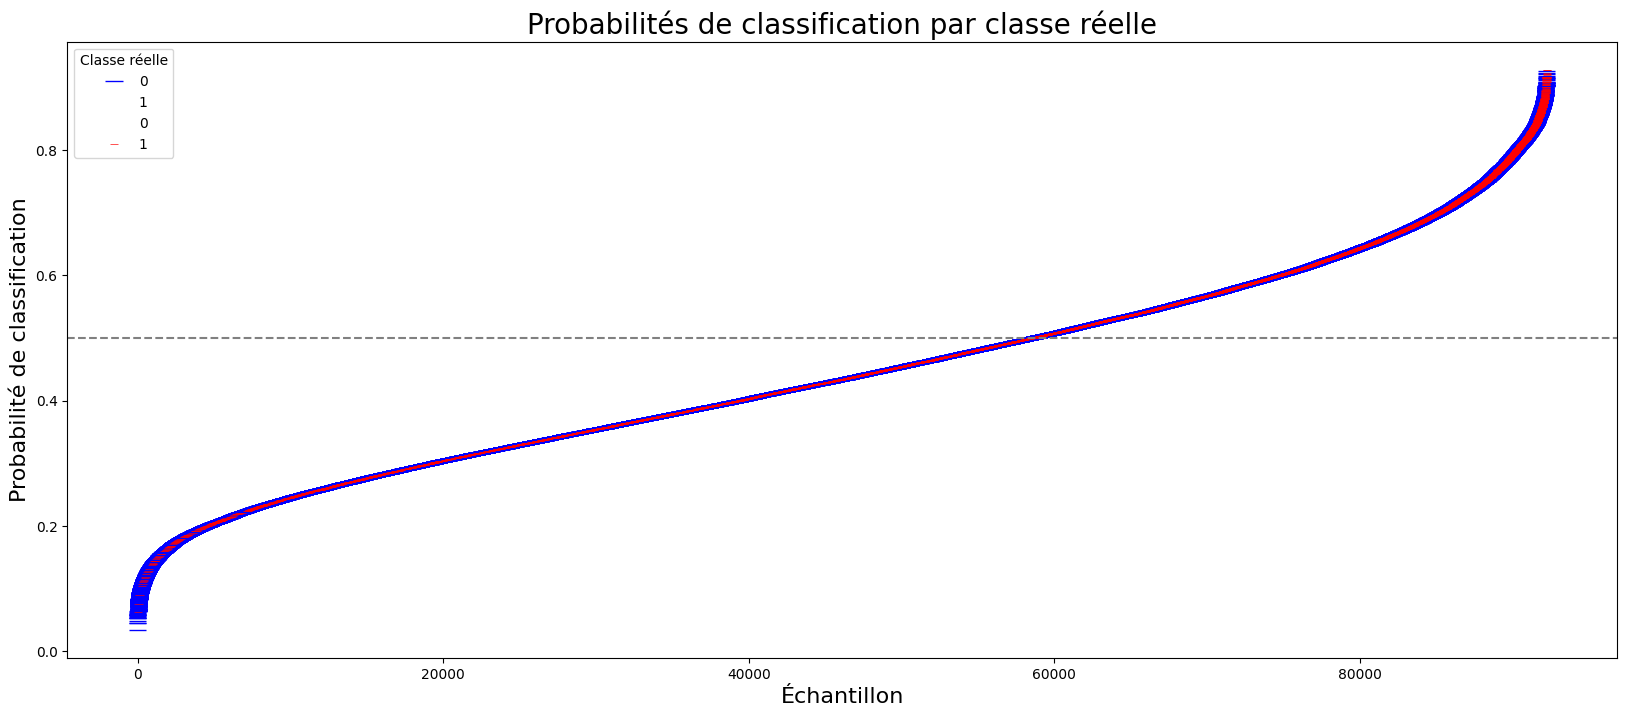

In [50]:
# Plot probability for all test sample and color with target values
plt.figure(figsize=(20, 8))
sns.scatterplot(x=range(len(prob_table)), y=prob_table["Probability"], hue=prob_table["TARGET"], palette={0: 'blue', 1: (0, 0, 0, 0)}, marker="_", s=150)
sns.scatterplot(x=range(len(prob_table)), y=prob_table["Probability"], hue=prob_table["TARGET"], palette={0: (0, 0, 0, 0), 1: 'r'}, marker="_")
plt.axhline(y=0.5,color='gray', linestyle='--')

plt.xlabel('Échantillon', fontsize=16)
plt.ylabel('Probabilité de classification', fontsize=16)
plt.title('Probabilités de classification par classe réelle', fontsize=20)
plt.legend(title='Classe réelle', loc='upper left')
plt.show()

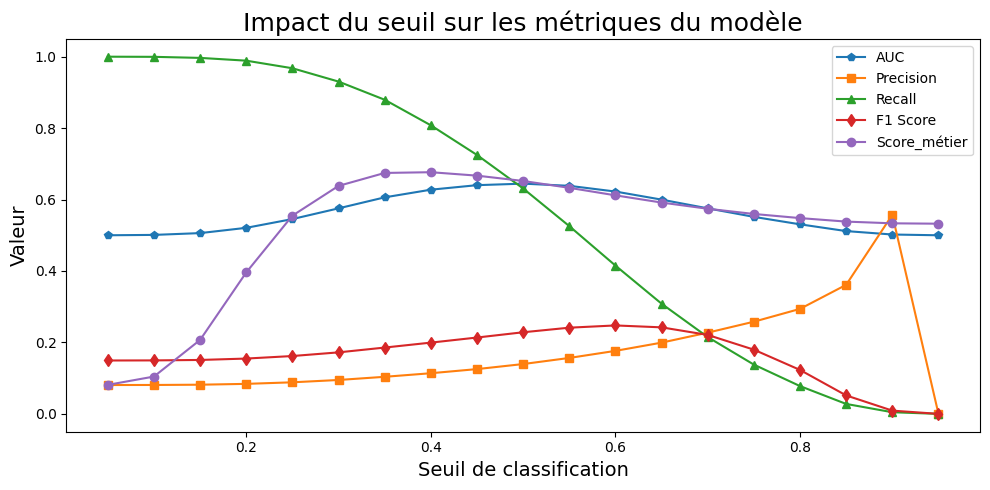

In [41]:
# Visualiser l'impact des seuils

plt.figure(figsize=(10, 5))
plt.plot(metrics[:, 0], metrics[:, 1], label="AUC", marker="p")
plt.plot(metrics[:, 0], metrics[:, 2], label="Precision", marker="s")
plt.plot(metrics[:, 0], metrics[:, 3], label="Recall", marker="^")
plt.plot(metrics[:, 0], metrics[:, 4], label="F1 Score", marker="d")
plt.plot(metrics[:, 0], metrics[:, 5], label="Score_métier", marker="o")

plt.xlabel("Seuil de classification", fontsize=14)
plt.ylabel("Valeur", fontsize=14)
plt.title("Impact du seuil sur les métriques du modèle", fontsize=18)
plt.legend()
plt.tight_layout()

plt.show()

In [59]:
results = pd.DataFrame(metrics)
results.rename(
    columns={0: "Seuil", 1: "AUC", 2: "precision", 3: "Recall", 4: "F1 score", 5: "Score_metier"},
    inplace=True,
)
results

,Seuil,AUC,precision,Recall,F1 score,Score_metier
0,0.05,0.500024,0.080738,1.000000,0.149413,0.081196
1,0.10,0.501060,0.080892,0.999597,0.149672,0.104447
2,0.15,0.506075,0.081649,0.996643,0.150934,0.207009
3,0.20,0.520859,0.083992,0.988856,0.154833,0.396000
4,0.25,0.545380,0.088352,0.967642,0.161920,0.554935
5,0.30,0.575405,0.094872,0.930317,0.172185,0.638281
6,0.35,0.606180,0.103769,0.879431,0.185634,0.674513
7,0.40,0.627624,0.113782,0.807868,0.199470,0.676592
8,0.45,0.640301,0.125334,0.724893,0.213716,0.666965
9,0.50,0.644558,0.139478,0.631042,0.228460,0.652028


In [60]:
# Better seuil using using my score_metier
results[results["Score_metier"] == results["Score_metier"].max()]

,Seuil,AUC,precision,Recall,F1 score,Score_metier
7,0.4,0.627624,0.113782,0.807868,0.19947,0.676592


## Feature importance

In [61]:
# Créer un explainer SHAP
# Appliquer les mêmes étapes de prétraitement que celles utilisées lors de l'entraînement
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Utiliser SHAP pour expliquer le modèle
explainer = shap.Explainer(loaded_model, feature_names=X_test.columns)
shap_values = explainer(X_test_scaled)

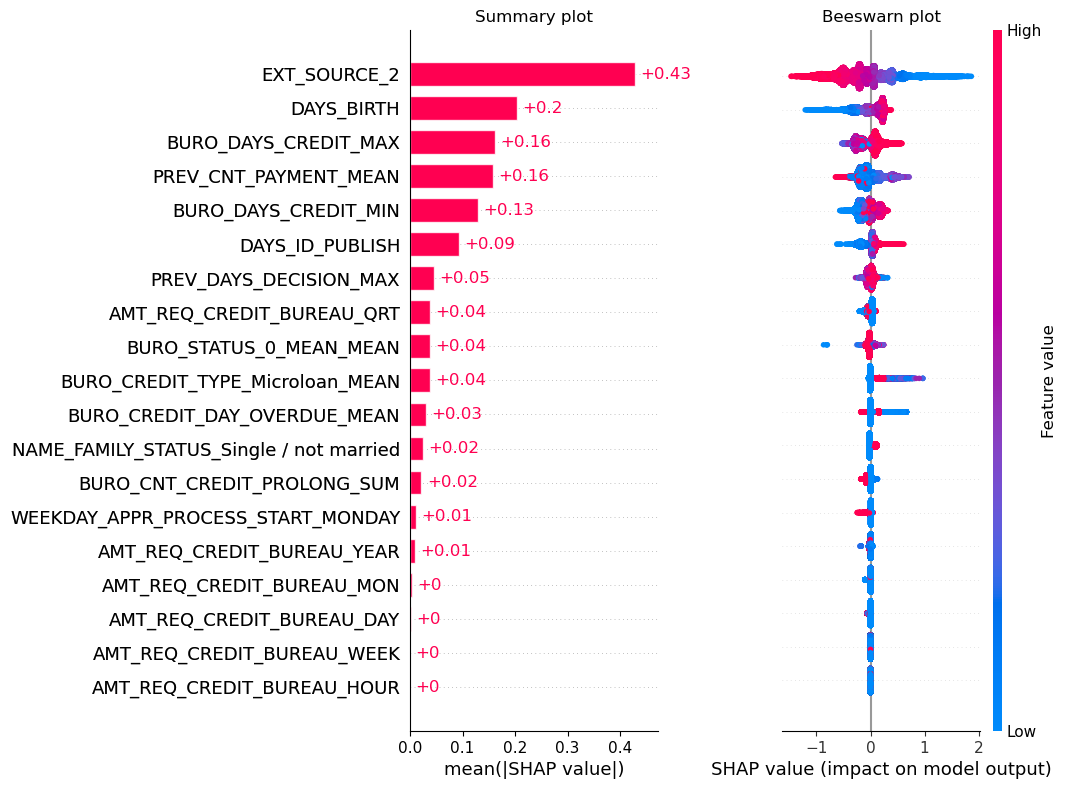

In [62]:
# Créez la figure avec deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), gridspec_kw={"wspace": 0.5})

# Premier graphique SHAP
shap.plots.bar(shap_values, max_display=25, show=False, ax=ax1)
ax1.set_title("Summary plot")

# Deuxième graphique SHAP
plt.sca(ax2)
shap.plots.beeswarm(shap_values, max_display=25, show=False)
ax2.set_title("Beeswarn plot")

# Supprimer les labels sur le second graphique
ax2.set_yticklabels([])
ax2.set_ylim(ax2.get_ylim()[0] * 1.5, ax2.get_ylim()[1] * 1.02)

# Ajustez la mise en page et affichez
plt.tight_layout()
plt.show()

EXT_SOURCE_2 : Normalized score from external data source
DAYS_BIRTH : Client's age in days at the time of application
BURO_DAYS_CREDIT_MAX : Maximum of how many days before current application did client apply for Credit Bureau credit
PREV_CNT_PAYMENT_MEAN : Mean of term of previous credit at application of the previous application
BURO_DAYS_CREDIT_MIN :Minimum of how many days before current application did client apply for Credit Bureau credit
CODE_GENDER : Gender of the client (M=1, F=0)
DAYS_ID_PUBLISH : How many days before the application did client change the identity document with which he applied for the loan

In [63]:
# List of feature with no participation to the result
to_drop = ["AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_HOUR"]

In [64]:
# Index of client who didn't paid his loan
np.where(y_test == 1)

(array([   18,    30,    42, ..., 92219, 92236, 92237]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [81]:
y_probs[79797]

0.034353074

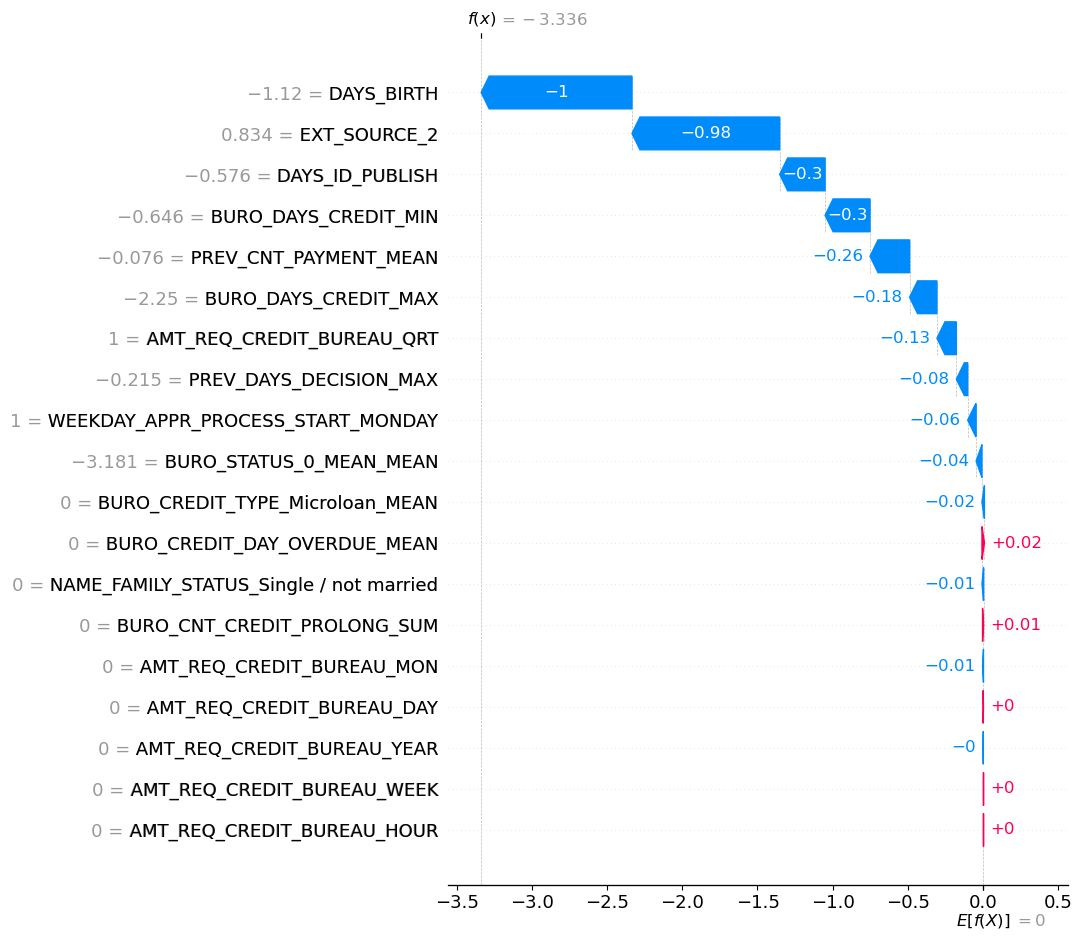

In [71]:
# Local feature of a client who paid his loan
shap.plots.waterfall(shap_values[79797], max_display=19)

In [82]:
y_probs[20479]

0.92806727

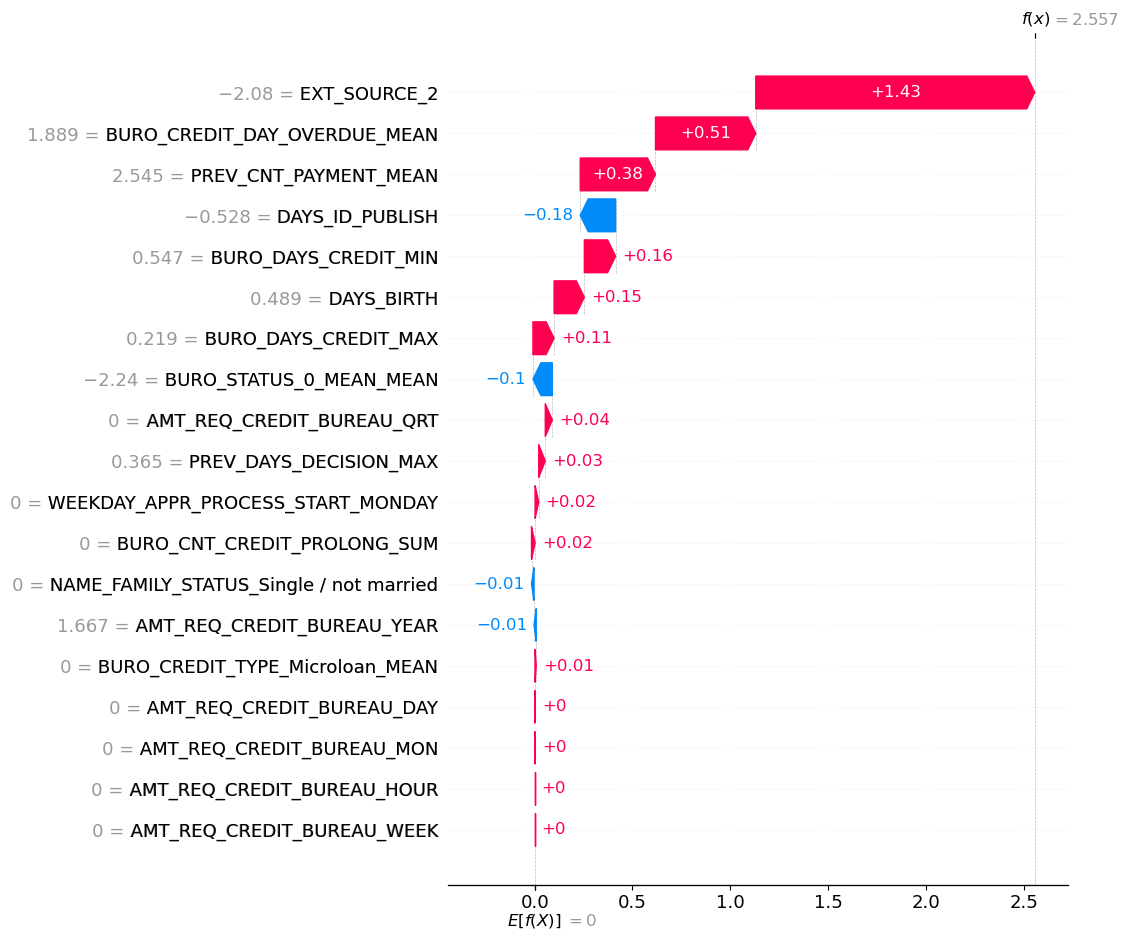

In [70]:
# Local feature of client who didn't paid his loan
shap.plots.waterfall(shap_values[20479], max_display=19)

In [72]:
# Remove useless features
X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

In [73]:
# Save the final data
X_train.to_csv("Data/cleaned/X_train_final.csv", index=False)
y_train = pd.DataFrame(y_train)
y_train.to_csv("Data/cleaned/y_train_final.csv", index=False)
X_test.to_csv("Data/cleaned/X_test_final.csv", index=False)
y_test = pd.DataFrame(y_test)
y_test.to_csv("Data/cleaned/y_test_final.csv", index=False)

test_data = pd.read_csv("Data/cleaned/data_test.csv")
test_data.drop(columns=to_drop, inplace=True)
test_data.to_csv("Data/cleaned/data4test_final.csv", index=False)

## Final model

In [74]:
# Load final data
X_train = pd.read_csv("Data/cleaned/X_train_final.csv")
y_train = pd.read_csv("Data/cleaned/y_train_final.csv")
y_train = y_train.values
X_test = pd.read_csv("Data/cleaned/X_test_final.csv")
y_test = pd.read_csv("Data/cleaned/y_test_final.csv")
y_test = y_test.values

In [75]:
# Best parameters for xgboost model
best_param = {'model__learning_rate': 0.3, 'model__max_depth': 3, 'model__n_estimators': 50, 'model__objective': 'binary:logistic',
'model__scale_pos_weight': 11.387293548944006, 'model__seed': 3}

In [76]:
# Pipeline including xgboost with best params
pipeline = Pipeline([("scaler", RobustScaler()), ("model", xgb.XGBClassifier(**best_param))])

In [77]:
# Train the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               model__learning_rate=0.3, model__max_depth=3,
                               model__n_estimators=50,
                               model__objective='binary:logistic',
                               model__scale_pos_weight=11.387293548944006,
                               model__seed=3, ...))])

In [78]:
# Connect to mlflow
mlflow.set_tracking_uri("http://127.0.0.1:8080")

# Sets the current experiment
imbalance_experiment = mlflow.set_experiment("Final_model")

In [79]:
# Creating the signature of the model
from mlflow.models.signature import infer_signature

signature = infer_signature(X_train, y_train)

In [80]:
# Save the model
with mlflow.start_run():
    mlflow.sklearn.log_model(
        pipeline, artifact_path="client_loan_prediction", signature=signature
    )

🏃 View run worried-newt-275 at: http://127.0.0.1:8080/#/experiments/222373925935893827/runs/88e39cf92d4f45f7a9764fead9fbc2bd
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/222373925935893827
